In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode
from pyspark.sql.types import StructType, ArrayType
from pyspark.sql import functions as F
from helper import read_sql_file, plot_multiple_line_graphs, plot_multiple_line_graphs2
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Big Data And Cloud Computing Laboratory Report

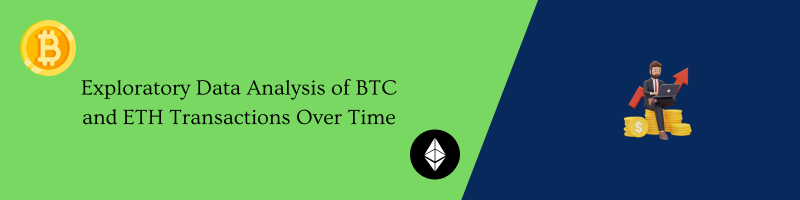

## EXECUTIVE SUMMARY

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

## INTRODUCTION

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

## Create Spark Session 

In [2]:
spark = SparkSession.builder.appName("BDCCLab").master("local[*]").getOrCreate()

In [3]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

## Show Raw Data Size 

In [4]:
!du -sh /mnt/data/public/aws-public-blockchain/v1.0/eth/transactions/

901G	/mnt/data/public/aws-public-blockchain/v1.0/eth/transactions/


In [5]:
# Size of data being processed:
!du -sh /mnt/data/public/aws-public-blockchain/v1.0/btc/transactions/

1.5T	/mnt/data/public/aws-public-blockchain/v1.0/btc/transactions/


## Read Raw Data

In [6]:
df_eth_trans = spark.read.option("mergeSchema", "true").parquet("/mnt/data/public/aws-public-blockchain/v1.0/eth/transactions/")

In [7]:
df_btc_trans = spark.read.option("mergeSchema", "true").parquet("/mnt/data/public/aws-public-blockchain/v1.0/btc/transactions/")

In [142]:
df_btc_blocks = spark.read.option("mergeSchema", "true").parquet("/mnt/data/public/aws-public-blockchain/v1.0/btc/blocks/")

## ETH Transactions Schema

In [8]:
df_eth_trans.printSchema()

root
 |-- gas: long (nullable = true)
 |-- hash: string (nullable = true)
 |-- input: string (nullable = true)
 |-- nonce: long (nullable = true)
 |-- value: double (nullable = true)
 |-- block_number: long (nullable = true)
 |-- block_hash: string (nullable = true)
 |-- transaction_index: long (nullable = true)
 |-- from_address: string (nullable = true)
 |-- to_address: string (nullable = true)
 |-- gas_price: long (nullable = true)
 |-- receipt_cumulative_gas_used: long (nullable = true)
 |-- receipt_gas_used: long (nullable = true)
 |-- receipt_contract_address: string (nullable = true)
 |-- receipt_status: long (nullable = true)
 |-- receipt_effective_gas_price: long (nullable = true)
 |-- transaction_type: long (nullable = true)
 |-- max_fee_per_gas: long (nullable = true)
 |-- max_priority_fee_per_gas: long (nullable = true)
 |-- block_timestamp: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- last_modified: timestamp (nullable = true)



Data Dictionary for ETH [1]

Field | Type | Description 
--- | --- | ---
date | string | Partition column (YYYY-MM-DD)
hash | string | Hash of the transaction
nonce | bigint | The number of transactions made by the sender prior to this one
transaction_index | bigint | Integer of the transactions index position in the block
from_address | string | Address of the sender
to_address | string | Address of the receiver
value | double | Value transferred in wei      
gas | bigint | Gas price provided by the sender in wei       
gas_price | bigint | Gas provided by the sender
input | string | The data sent along with the transaction
receipt_cumulative_gas_used | bigint | The total amount of gas used when this transaction was executed in the block
receipt_gas_used | bigint | The amount of gas used by this specific transaction alone
receipt_contract_address | string | The contract address created, if the transaction was a contract creation
receipt_status | bigint | If the transaction was successful
block_timestamp | timestamp | The unix timestamp for when the block was collated
block_number | bigint | Block number where this transaction was in
block_hash | string | Hash of the block
max_fee_per_gas | bigint | Total fee that covers both base and priority fees
max_priority_fee_per_gas | bigint | Fee given to miners to incentivize them to include the transaction
transaction_type | bigint | Transaction type
receipt_effective_gas_price | bigint | The actual value per gas deducted from the senders account.

## BTC Transactions Schema

In [9]:
df_btc_trans.printSchema()

root
 |-- hash: string (nullable = true)
 |-- version: long (nullable = true)
 |-- size: long (nullable = true)
 |-- block_hash: string (nullable = true)
 |-- block_number: long (nullable = true)
 |-- virtual_size: long (nullable = true)
 |-- lock_time: long (nullable = true)
 |-- input_count: long (nullable = true)
 |-- output_count: long (nullable = true)
 |-- is_coinbase: boolean (nullable = true)
 |-- output_value: double (nullable = true)
 |-- outputs: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- index: long (nullable = true)
 |    |    |-- required_signatures: long (nullable = true)
 |    |    |-- script_asm: string (nullable = true)
 |    |    |-- script_hex: string (nullable = true)
 |    |    |-- type: string (nullable = true)
 |    |    |-- value: double (nullable = true)
 |    |    |-- address: string (nullable = true)
 |-- block_timestamp: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- index: long (nullable = tru

Data Dictionary for BTC [2]

Field | Nested Field | Type | Description 
--- | --- | --- | ---
date | | string | Partition column (YYYY-MM-DD)
hash | | string | The hash of this transaction
size | | bigint | The size of this transaction in bytes
virtual_size | | bigint | The virtual transaction size (differs from size for witness transactions)
version | | bigint | Protocol version specified in block which contained this transaction
lock_time | | bigint | Earliest time that miners can include the transaction in their hashing of the Merkle root to attach it in the latest block of the blockchain
block_hash | | string | Hash of the block which contains this transaction
block_number | | bigint | Number of the block which contains this transaction
block_timestamp | | timestamp | Timestamp of the block which contains this transaction
index | | bigint | The index of the transaction in the block
input_count | | bigint | The number of inputs in the transaction
output_count | | bigint | The number of outputs in the transaction
input_value | | double | Total value of inputs in the transaction (in BTC)
output_value | | double | Total value of outputs in the transaction (in BTC)
is_coinbase | | boolean | True if this transaction is a coinbase transaction
fee | | double | The fee paid by this transaction
inputs | | array | Transaction inputs
inputs | index | bigint | 0 indexed number of an input within a transaction
inputs | spent_transaction_hash | string | The hash of the transaction which contains the output that this input spends
inputs | spent_output_index | bigint | The index of the output this input spends
inputs | script_asm | string | Symbolic representation of the bitcoins script language op-codes
inputs | script_hex | string | Hexadecimal representation of the bitcoins script language op-codes
inputs | sequence | bigint | A number intended to allow unconfirmed time-locked transactions to be updated before being finalized; not currently used except to disable locktime in a transaction
inputs | required_signatures | bigint | The number of signatures required to authorize the spent output
inputs | type | string | The address type of the spent output
inputs | address | string | Address which owns the spent output
inputs | value | double | The value in BTC attached to the spent output
outputs | | array | Transaction outputs
outputs | index | bigint | 0 indexed number of an output within a transaction used by a later transaction to refer to that specific output
outputs | script_asm | string | Symbolic representation of the bitcoins script language op-codes
outputs | script_hex | string | Hexadecimal representation of the bitcoins script language op-codes
outputs | required_signatures | bigint | The number of signatures required to authorize spending of this output
outputs | type | string | The address type of the output
outputs | address | string | Address which owns this output
outputs | value | double | The value in BTC attached to this output

In [147]:
df_btc_blocks.printSchema()

root
 |-- hash: string (nullable = true)
 |-- version: long (nullable = true)
 |-- mediantime: timestamp (nullable = true)
 |-- nonce: long (nullable = true)
 |-- bits: string (nullable = true)
 |-- difficulty: double (nullable = true)
 |-- chainwork: string (nullable = true)
 |-- size: long (nullable = true)
 |-- weight: long (nullable = true)
 |-- coinbase_param: string (nullable = true)
 |-- number: long (nullable = true)
 |-- transaction_count: long (nullable = true)
 |-- merkle_root: string (nullable = true)
 |-- stripped_size: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- previousblockhash: string (nullable = true)
 |-- last_modified: timestamp (nullable = true)



## Register Temporary Views

In [143]:
df_eth_trans.createOrReplaceTempView("df_eth_trans")
df_btc_trans.createOrReplaceTempView("df_btc_trans")
df_btc_blocks.createOrReplaceTempView("df_btc_blocks")

## BTC and ETH Comparisons on Count and Total and Average Value and Fees

In [56]:
eth_tot_trans = spark.sql("""
WITH value AS (
	SELECT 
        year(date) AS year, 
        AVG(value/1E18) AS avg_value,
        AVG(CASE 
                WHEN receipt_status = 1 AND receipt_effective_gas_price > 0 
                THEN receipt_effective_gas_price/1E18 
                ELSE 0 
            END) AS avg_gas,
        SUM(value/1E18) AS total_value,
        SUM(CASE 
                WHEN receipt_status = 1 AND receipt_effective_gas_price > 0 
                THEN receipt_effective_gas_price/1E18 
                ELSE 0 
            END) AS total_gas,
        COUNT(*) AS count
	FROM df_eth_trans
	GROUP BY year(date)
	ORDER BY year
)
SELECT
	year,
	total_value,
    total_gas,
    avg_value,
    avg_gas,
    count AS total_transactions
FROM value;
 
""").toPandas()
eth_tot_trans

,year,total_value,total_gas,avg_value,avg_gas,total_transactions
0,2015,9.184474e+07,0.066232,87.781841,6.330245e-08,1046284
1,2016,6.625570e+08,0.409877,48.499609,3.000327e-08,13661080
2,2017,4.353256e+09,2.557807,42.288832,2.484730e-08,102941034
3,2018,1.142012e+09,5.449470,4.546831,2.169664e-08,251166529
4,2019,7.653053e+08,3.824180,3.151582,1.574825e-08,242832115
5,2020,9.428725e+08,23.000077,2.734811,6.671195e-08,344766970
6,2021,9.920981e+08,47.371433,2.148294,1.025783e-07,461807363
7,2022,6.946280e+08,19.230624,1.700256,4.707121e-08,408543268
8,2023,4.534225e+08,12.622046,1.183560,3.294708e-08,383100651
9,2024,1.851720e+08,4.934517,1.192735,3.178433e-08,155249958


In [14]:
btc_tot_trans = spark.sql("""
WITH value AS (
	SELECT 
        year(date) AS year, 
        AVG(input_value) AS avg_value,
        AVG(fee) AS avg_fee,
        SUM(input_value) AS total_value,
        SUM(fee) AS total_fee,
        COUNT(*) AS count
	FROM df_btc_trans
	GROUP BY year(date)
	ORDER BY year
)
SELECT
	year,
	avg_value,
    avg_fee,
    total_value,
    total_fee,
    count AS total_transactions
FROM value;
""").toPandas()
btc_tot_trans

,year,avg_value,avg_fee,total_value,total_fee,total_transactions
0,2009,230.000000,0.000000,1.150000e+03,0.000000,32709
1,2010,134.682635,0.000229,1.271040e+07,21.591013,185305
2,2011,160.148884,0.001676,2.948767e+08,3086.340796,1901765
3,2012,109.886395,0.000811,9.168147e+08,6766.706688,8453050
4,2013,21.875829,0.000780,4.283245e+08,15274.635981,19643241
5,2014,10.422027,0.000184,2.626857e+08,4636.574089,25263720
6,2015,11.955067,0.000180,5.391198e+08,8109.502888,45674023
7,2016,12.927879,0.000273,1.067038e+09,22548.383140,82626623
8,2017,8.960290,0.000965,9.319356e+08,100370.686083,104063229
9,2018,5.174042,0.000315,4.196391e+08,25544.523016,81395636


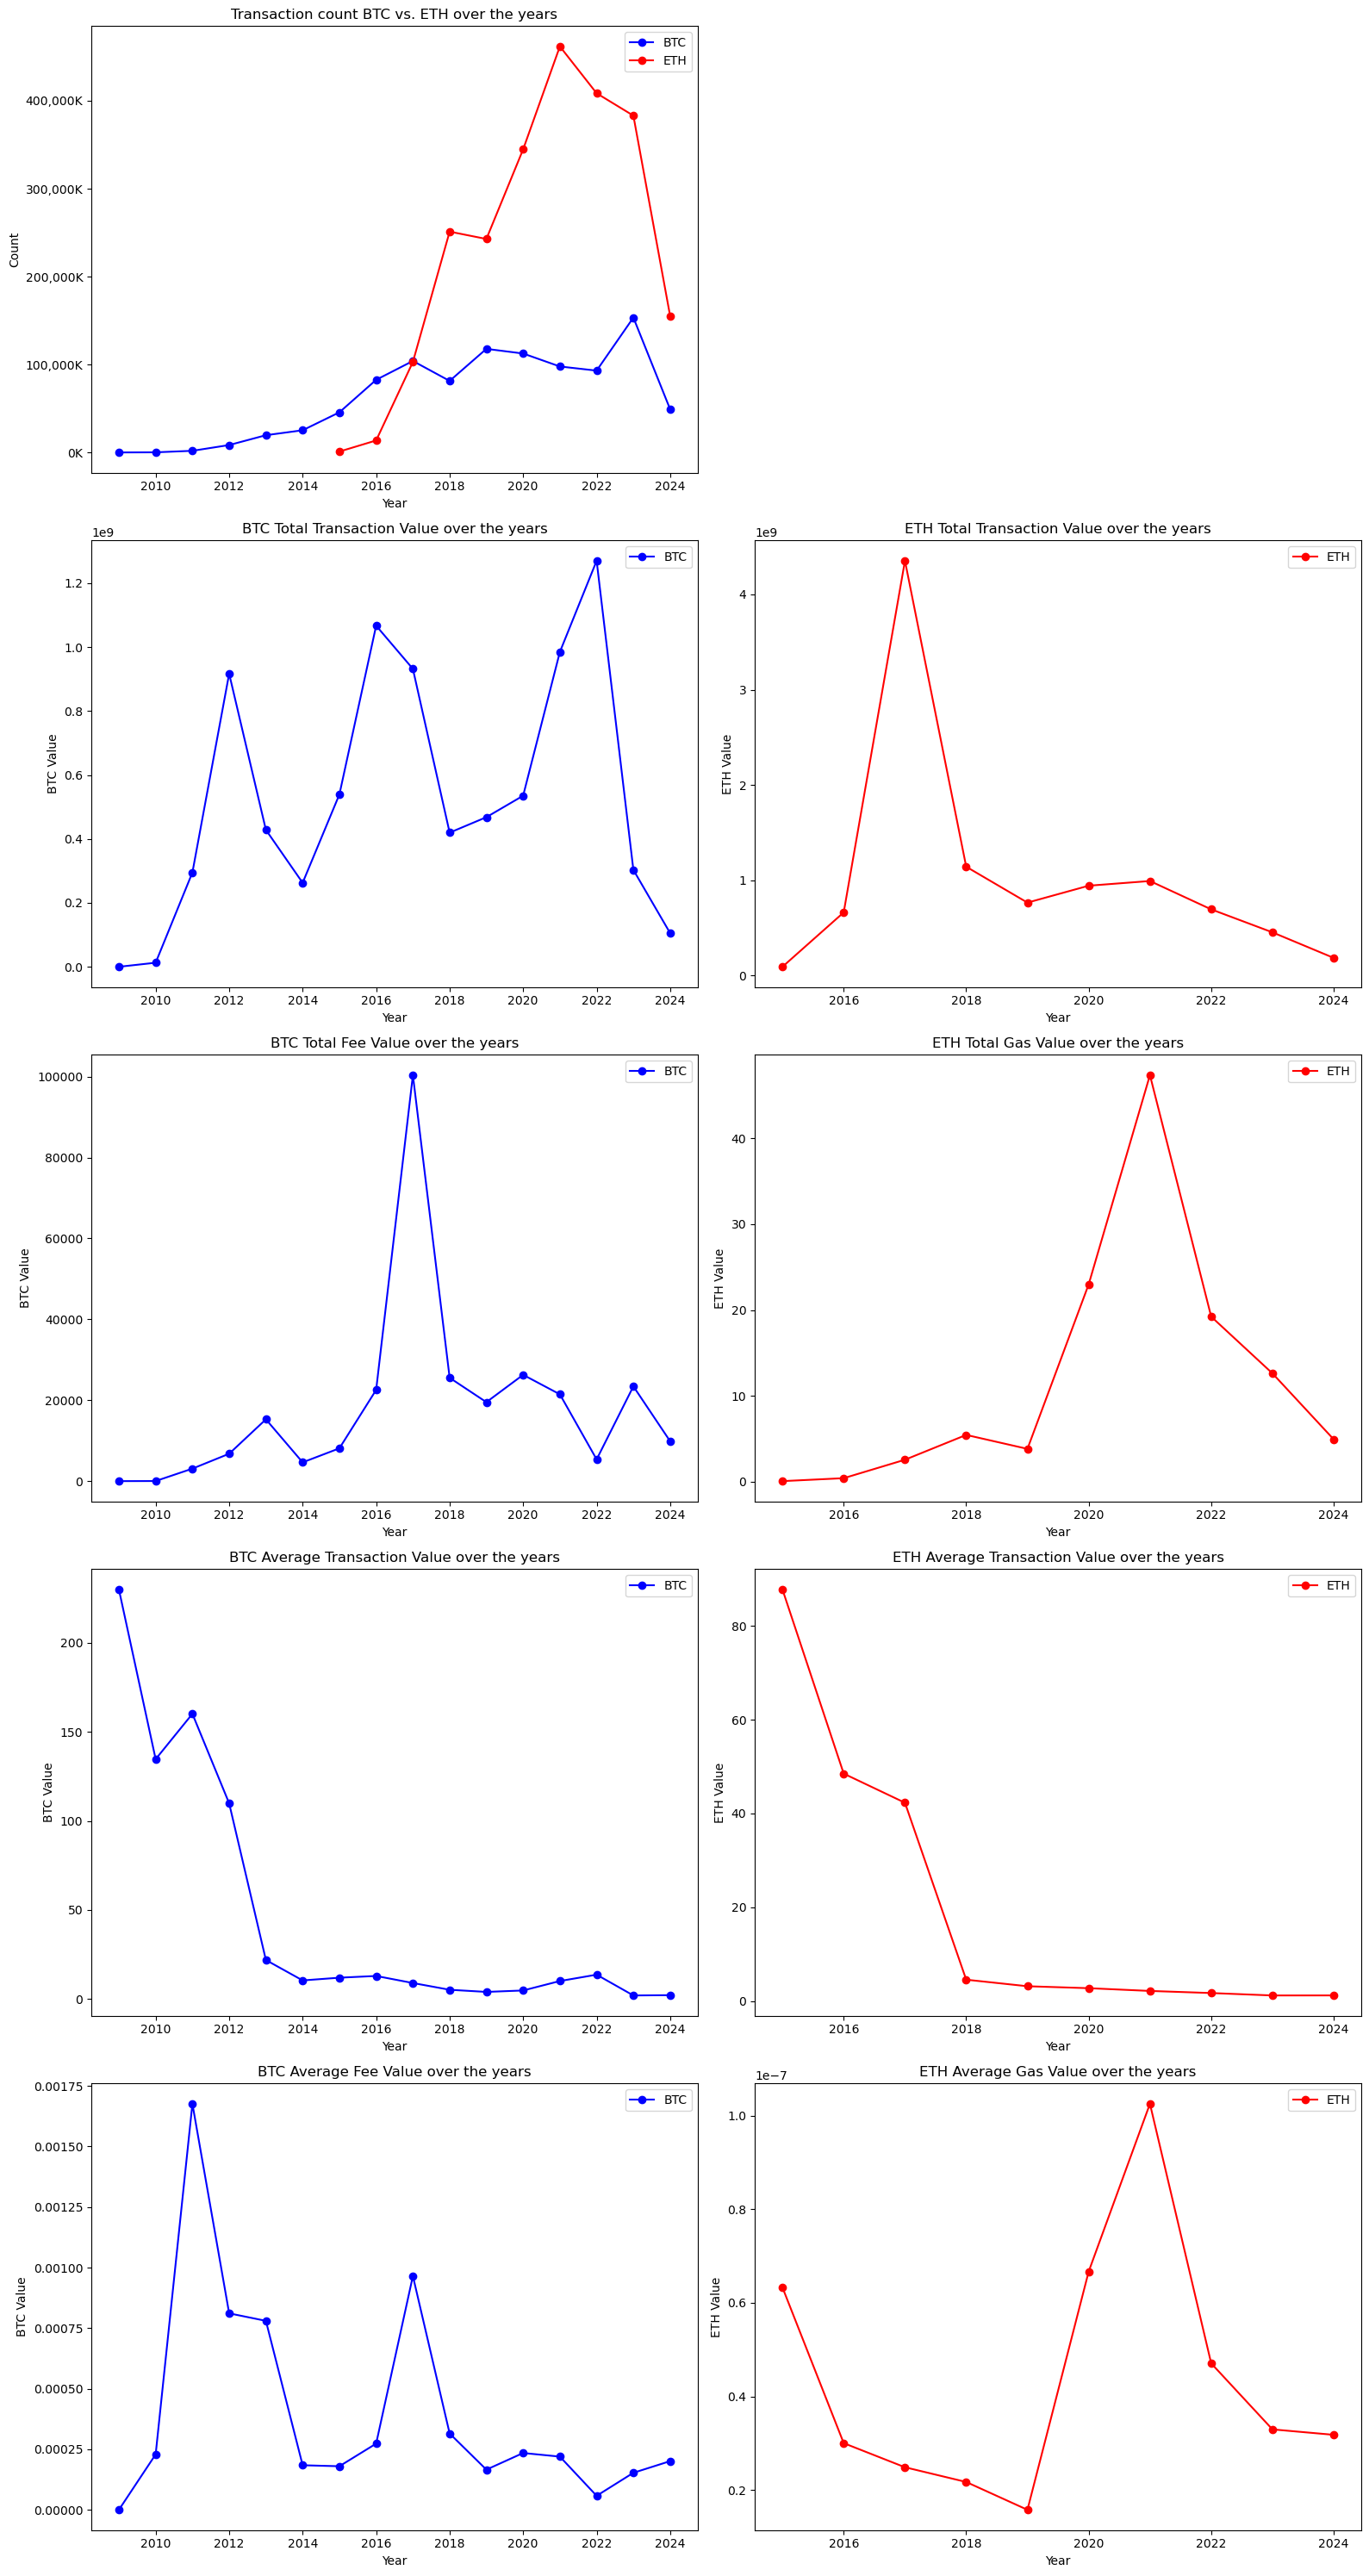

In [113]:
plot_multiple_line_graphs2(
    x_list=[[btc_tot_trans["year"], eth_tot_trans["year"]], None,] + [btc_tot_trans["year"], eth_tot_trans["year"]] * 4,
    y_list=[
        [
            (btc_tot_trans["total_transactions"], "BTC", "b"),
            (eth_tot_trans["total_transactions"], "ETH", "r"),
        ],
        [],
        (btc_tot_trans["total_value"], "BTC", "b"), 
        (eth_tot_trans["total_value"], "ETH", "r"),
        (btc_tot_trans["total_fee"], "BTC", "b"), 
        (eth_tot_trans["total_gas"], "ETH", "r"),
        (btc_tot_trans["avg_value"], "BTC", "b"),
        (eth_tot_trans["avg_value"], "ETH", "r"),
        (btc_tot_trans["avg_fee"], "BTC", "b"), 
        (eth_tot_trans["avg_gas"], "ETH", "r"),
    ],
    x_labels=["Year",] * 10,
    y_labels=["Count", "",] + ["BTC Value", "ETH Value"]*4,
    titles=[
        "Transaction count BTC vs. ETH over the years", 
        "", 
        "BTC Total Transaction Value over the years", 
        "ETH Total Transaction Value over the years", 
        "BTC Total Fee Value over the years", 
        "ETH Total Gas Value over the years", 
        "BTC Average Transaction Value over the years", 
        "ETH Average Transaction Value over the years", 
        "BTC Average Fee Value over the years", 
        "ETH Average Gas Value over the years", 
    ],
    use_k=[True] + [False] * 9,
    use_legend=[True] * 10,
    show_grid=False,
    max_cols=2
)

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

## ETH and BTC Transactions Per Second

In [16]:
tps_trans = spark.sql("""
WITH eth_daily_txn AS (
    SELECT 
        date, 
        CAST(count(*) AS double) / (24 * 60 * 60) AS eth_transactions_per_sec
    FROM df_eth_trans
    GROUP BY date
), btc_daily_txn AS (
    SELECT 
        date, 
        CAST(count(*) AS double) / (24 * 60 * 60) AS btc_transactions_per_sec
    FROM df_btc_trans
    GROUP BY date
)
SELECT 
    YEAR(coalesce(eth.date, btc.date)) AS year,
    AVG(eth.eth_transactions_per_sec) AS eth_transactions_per_sec,
    AVG(btc.btc_transactions_per_sec) AS btc_transactions_per_sec
FROM eth_daily_txn eth
FULL OUTER JOIN btc_daily_txn btc ON eth.date = btc.date
GROUP BY year
ORDER BY year
""").toPandas().fillna(0)
tps_trans

,year,eth_transactions_per_sec,btc_transactions_per_sec
0,2009,0.000000,0.001057
1,2010,0.000000,0.005876
2,2011,0.000000,0.060305
3,2012,0.000000,0.267312
4,2013,0.000000,0.622883
5,2014,0.000000,0.801107
6,2015,0.082379,1.448314
7,2016,0.432006,2.612914
8,2017,3.264239,3.299823
9,2018,7.964438,2.581039


Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

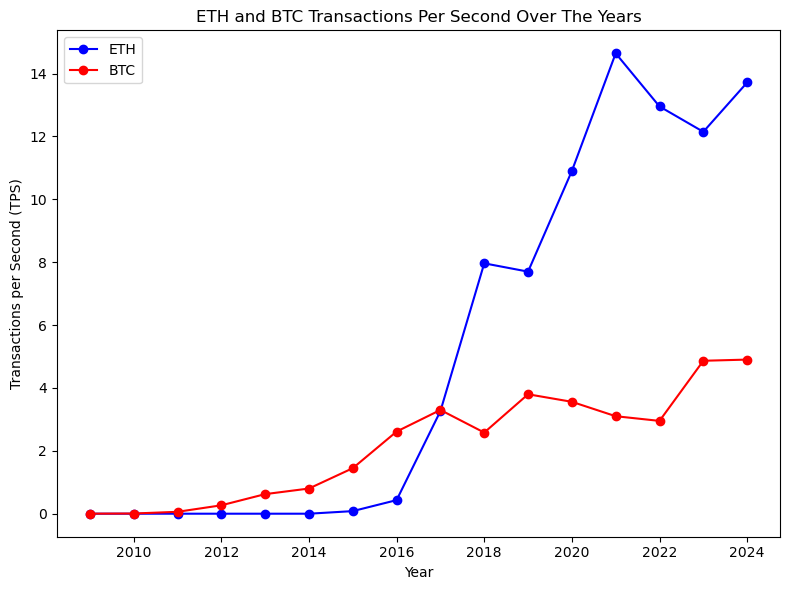

In [133]:
plot_multiple_line_graphs2(
    x_list=[[tps_trans["year"]]*2],
    y_list=[[[tps_trans["eth_transactions_per_sec"], "ETH", "b"], [tps_trans["btc_transactions_per_sec"], "BTC", "r"]]],
    x_labels=["Year"],
    y_labels=["Transactions per Second (TPS)"],
    titles=["ETH and BTC Transactions Per Second Over The Years"],
    use_k=[False],
    use_legend=[True],
    show_grid=False,
    max_cols=1,
)

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

In [128]:
# import pandas as pd
# import math
# import matplotlib.pyplot as plt
# from matplotlib.ticker import FuncFormatter


# def thousands_formatter(x, pos):
#     """Convert large numbers to thousands with 'K' suffix."""
#     return f'{x * 1e-3:,.0f}K'

# def plot_multiple_line_graphs2(
#     x_list, y_list, x_labels=None, y_labels=None, titles=None,
#     use_k=None, use_legend=None, show_grid=False, max_cols=3,
# ):
#     """
#     Plots multiple line graphs in subplots and formats the y-axis in thousands.
#     Dynamically sets the layout to a maximum of 3 columns.

#     Parameters:
#     x_list (list of pd.Series or array-like): List of data for the X-axes
#     y_list (list of pd.Series or array-like): List of data for the Y-axes
#     x_labels (list of str): List of labels for the X-axes
#     y_labels (list of str): List of labels for the Y-axes
#     titles (list of str): List of titles for each subplot
#     use_k (bool): Whether to format the y-axis in thousands
#     show_grid (bool): Whether to show grid on each plot
#     """
#     n_plots = len(x_list)
#     n_cols = min(n_plots, max_cols)
#     n_rows = math.ceil(n_plots / max_cols)

#     fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))

#     # Ensure axes is iterable, even for single plots
#     if n_rows == 1 and n_cols == 1:
#         axes = [[axes]]
#     elif n_rows == 1:
#         axes = [axes]
#     elif n_cols == 1:
#         axes = [[ax] for ax in axes]

#     # Flatten axes for easy indexing
#     axes = [ax for sublist in axes for ax in sublist]

#     for i, (use_legend_, use_k_, x, y) in enumerate(zip(use_legend, use_k, x_list, y_list)):
#         ax = axes[i]

#         if y == []:
#             ax.axis('off')
#             continue
        
#         # Check if x and y are lists or array-like
#         if isinstance(x, (list, pd.Series)) and isinstance(y, (list, pd.Series)):
#             for x_, y_ in zip(x, y):
#                 ax.plot(x_, y_[0], marker='o', linestyle='-', color=y_[2], label=y_[1])
#                 if use_legend_:
#                     ax.legend()
#         else:
#             ax.plot(x, y[0], marker='o', linestyle='-', color=y[2], label=y[1])
#             if use_legend_:
#                     ax.legend()

#         # Labels and title
#         ax.set_xlabel(x_labels[i] if x_labels else 'X-axis')
#         ax.set_ylabel(y_labels[i] if y_labels else 'Y-axis')
#         ax.set_title(titles[i] if titles else f'Graph {i+1}')

#         # Format the y-axis to show values in thousands
#         if use_k_:
#             ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

#         # Show grid
#         ax.grid(show_grid)

#     # Hide any unused axes
#     for j in range(i + 1, len(axes)):
#         fig.delaxes(axes[j])

#     # Adjust layout
#     plt.tight_layout()
#     plt.show()

## Read Coingecko API Historical Daily Prices of BTC and ETH

In [117]:
eth_prices = spark.read.csv("crypto_prices/eth-usd-max.csv", header=True)
btc_prices = spark.read.csv("crypto_prices/btc-usd-max.csv", header=True)
eth_prices.createOrReplaceTempView("eth_prices")
btc_prices.createOrReplaceTempView("btc_prices")

## BTC and ETCH Transaction Volume in USD using Coingecko Historical Prices

In [141]:
volume = spark.sql("""
WITH eth_prices_ AS (
    SELECT 
        TO_DATE(snapped_at) as date, 
        price as eth_price
    FROM eth_prices
), btc_prices_ AS (
    SELECT 
        TO_DATE(snapped_at) as date, 
        price as btc_price
    FROM Btc_prices
), combined_prices as (
SELECT
    COALESCE(b.date, e.date) as date, 
    e.eth_price,
    b.btc_price
FROM btc_prices_ b
LEFT JOIN eth_prices_ e
    ON b.date = e.date
), daily_amt_eth AS (
    SELECT 
        TO_DATE(date) AS date, 
        sum(value/1E18) AS amt 
    FROM df_eth_trans
    GROUP BY date
), daily_amt_btc AS (
    SELECT 
        TO_DATE(date) AS date, 
        sum(input_value) AS amt 
    FROM df_btc_trans
    GROUP BY date
), A as (
    select 
        YEAR(coalesce(a.date, b.date)) AS year,
        SUM(a.amt * b.eth_price) as volume
    from daily_amt_eth a
    JOIN eth_prices_ b
        ON a.date = b.date
    GROUP BY year
    ORDER BY year
), B as (
        select 
        YEAR(coalesce(a.date, b.date)) AS year,
        SUM(a.amt * b.btc_price) as volume
    from daily_amt_btc a
    JOIN btc_prices_ b
        ON a.date = b.date
    GROUP BY year
    ORDER BY year
)
SELECT
    b.year,
    a.volume as eth_vol_usd,
    b.volume as btc_vol_usd
FROM A a
FULL OUTER JOIN B b
    ON a.year = b.year
ORDER BY year
""").toPandas().fillna(0)
volume

,year,eth_vol_usd,btc_vol_usd
0,2013,NaN,7.713772e+10
1,2014,NaN,1.340974e+11
2,2015,1.023266e+08,1.619858e+11
3,2016,6.897527e+09,5.564227e+11
4,2017,1.098248e+12,3.747492e+12
5,2018,7.668154e+11,3.389282e+12
6,2019,1.419953e+11,3.409980e+12
7,2020,3.133019e+11,6.449999e+12
8,2021,2.555531e+12,4.815111e+13
9,2022,1.353725e+12,3.898312e+13


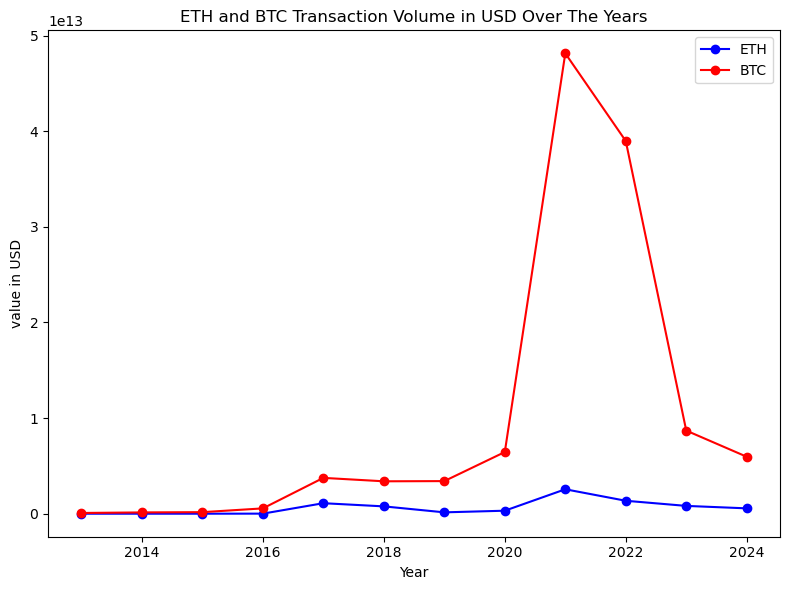

In [146]:
plot_multiple_line_graphs2(
    x_list=[[volume["year"]]*2],
    y_list=[[[volume["eth_vol_usd"], "ETH", "b"], [volume["btc_vol_usd"], "BTC", "r"]]],
    x_labels=["Year"],
    y_labels=["value in USD"],
    titles=["ETH and BTC Transaction Volume in USD Over The Years"],
    use_k=[False],
    use_legend=[True],
    show_grid=False,
    max_cols=1,
)

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

## Total Supply of Bitcoin Over The Years

In [158]:
tps_trans = spark.sql("""
select year, (CASE 
  WHEN number<210000 THEN 50*number
  WHEN number<420000 THEN (210000-1)*50+25*(number-210000) 
  WHEN number<630000 THEN (210000-1)*50+25*210000+12.5*(number-420000)
  ELSE (210000-1)*50+25*210000+12.5*210000+6.25*(number-630000) 
  END) as reward
from (
    select 
        year(TO_DATE(date)) as year,
        max(number) as number 
    from df_btc_blocks 
    group by year
) order by year 
""").toPandas()
tps_trans

,year,reward
0,2009,1624450.00
1,2010,5020450.00
2,2011,8001800.00
3,2012,10614000.00
4,2013,12199825.00
5,2014,13671450.00
6,2015,15029475.00
7,2016,16075350.00
8,2017,16774450.00
9,2018,17455675.00


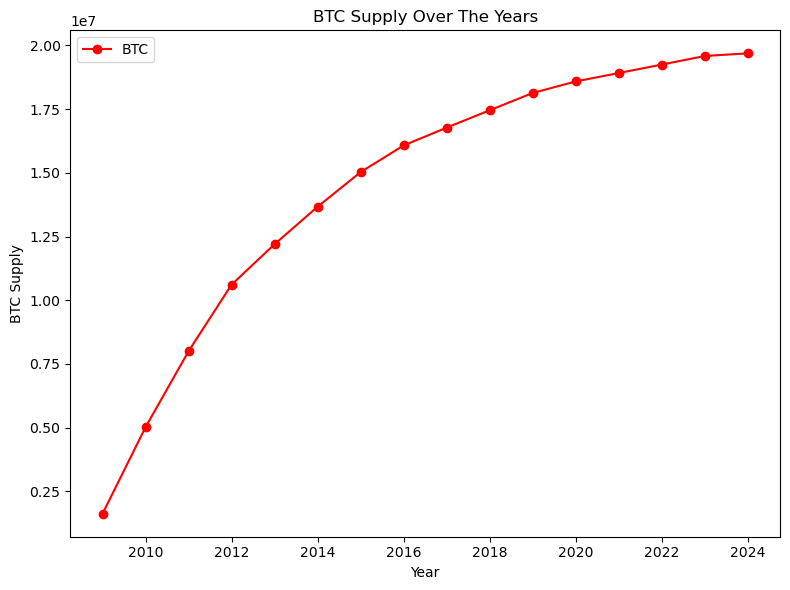

In [160]:
plot_multiple_line_graphs2(
    x_list=[tps_trans["year"]],
    y_list=[
        (tps_trans["reward"], "BTC", "r",)
    ],
    x_labels=["Year"],
    y_labels=["BTC Supply"],
    titles=["BTC Supply Over The Years"],
    use_k=[False],
    use_legend=[True],
    show_grid=False,
    max_cols=1,
)

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

## References

[1] https://github.com/aws-solutions-library-samples/guidance-for-digital-assets-on-aws/blob/main/analytics/consumer/schema/eth.md \
[2] https://github.com/aws-solutions-library-samples/guidance-for-digital-assets-on-aws/blob/main/analytics/consumer/schema/btc.md 